In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

#### Repeatable random: Always set a seed!

In [4]:
import numpy as np
np.random.seed(17)

# Modelling a Stock Market Exhibiting Inertia

### Expected perceived value

The *expected perceived value* (EPV) of an asset models the asset's *intrinsic value* in a hypothetical and perfectly efficient market. While the latter is not measurable, the former certainly provides a good estimate as it represents the value you would get after averaging over a very large number of interviews with traders. 

Expressly, we define the *expected perceived value* of an equity by:

$$
\psi(t) = \psi_0 e^{\frac{t}{T} \nu \cdot (1+\phi(t))}
$$

where t is the time measured in days from the beginning of the experiment, $\Psi_0$ is the initial *expected perceived value* (EPV), $\nu$ is the growth exponent defined with the help of the expected compound annual growth rate $\mathbb{E}(cagr)$ in the absence of any influential sentiment. $T$ is the duration of the trading period after which the EPV has been reached.

$$
\nu = ln(1+\mathbb{E}(cagr))
$$ 

Now, we model $\phi(t): \mathbb{N}^+ \rightarrow [-\infty, 1]$ as a piece-wise linear, (potentially) non-continuous function over time, representing the sentiment of the trading community with regards to the given asset. A positive sentiment thus has a direct influence on the expected perceived value of the asset.

A neutral sentiment of $\phi(t)=0$ over the entire period would mean that it is maximum likely to meet its expected $cagr$. Obviously, a negative sentiment will cause the stock value to decline over time. We allow it do decline arbitrarily rapidly by allowing $\phi$ to yield very large negative values. A sudden change in the sentiment, thus, explicitly leads to a sudden plunge or surge in the expected perceived value EPV. With those sudden changes we can model earnings surprises or any unexpected good or bad news.

In our playground, a year has four equally long quarters of 64 business days each. That's close to a real-world year and good for GPU performance. 


### Modelling sectors and geo-markets

Not only stocks but also market segments or even entire markets are influenced by sentiment. That's being covered by our ```GeoMarket``` and ```Segment``` classes.

In [5]:
from markets.dynamic_market import Segment, GeoMarket, Stock

#### Piece-wise linear functions for segment and geo-market sentiment

In [6]:
it = Segment(name="Information Technology", sentiments={
    0: (0.1, 2e-3),
    64: (.3, 0),
    128: (.25, -1e-3),
    192: (.1, 1e-3)
})

us = GeoMarket(name="United States", sentiments={
    0: (0.1, 0),
    128: (.25, 1e-3)
})
europe = GeoMarket(name="Europe", sentiments={
    0: (0.1, -1e-3),
    192: (-.025, 5e-4)
})

Here's what the IT sector's und US market's sentiment looks like over the year. We model positive and negative earnings surprises and some slowly changing sentiment over time between the earnings calls. In the US market case that may be some news about the impeachment process.

In [7]:
from utils.chartutils import plot_many

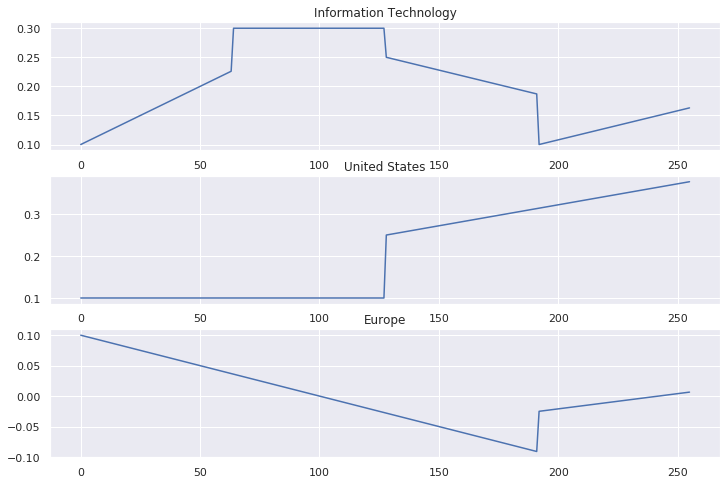

In [8]:
plot_many(3, 1, 12, 8, data=[
    [[[it.phi(t) for t in range(256)]]],
    [[[us.phi(t) for t in range(256)]]],
    [[[europe.phi(t) for t in range(256)]]],
], titles=["Information Technology", "United States", "Europe"]);

### Modelling Stocks
Stocks themselves have sentiment attached, and they have exposures to markets and segments on top. 

In [9]:
aapl_sentiments = {
    0: (.01, 0),         # start bullish for the first 90 days 
    64: (.05, .05/64),   # cool down a bit but recover well
    128: (-.03, .2/64),   # bad earnings, still recovering well
    192: (.04, 0),      # good sentiment
} 
ibm_sentiments = {
    0: (.02, 0),         # start bullish for the first 90 days 
    64: (.03, .05/64),   # cool down a bit but recover well
    128: (-.02, .02/64),   # bad earnings, still recovering well
    192: (.05, 0),      # good sentiment
} 

In [10]:
aapl = Stock(name='AAPL', psi0=100, e_cagr=1, max_effect=2.0,
             segments = {it: 1.0}, 
             markets={us: 0.5, europe: .3},
             sentiments=aapl_sentiments, noise=2.0)

ibm = Stock(name='IBM', psi0=110, e_cagr=.1, max_effect=2.0,
             segments = {it: 1.0}, 
             markets={us: 0.1, europe: .2},
             sentiments=ibm_sentiments, noise=2.0)

I have chosen a very large $\mathbb{E}(cagr)$ for AAPL to make the exponential growth in $\Psi(t)$ visible.

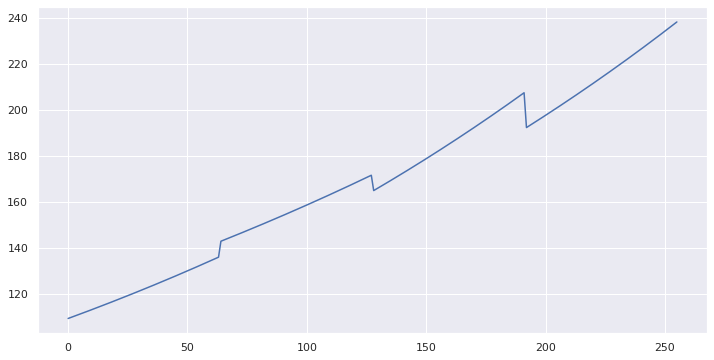

In [11]:
plt.plot([aapl.psi(t) for t in range(256)]);

### Modelling the market and its investors
We use a simplified model where the market is actually always providing liquidity itself. So, if I want to buy something, the market itself is the counterparty. It would be interesting, though, to model something more realistic in future versions of this tutorial. 

In [12]:
from markets.dynamic_market import Market, Ask, Bid, MomentumInvestor

In [13]:
market = Market(stocks = [ibm, aapl], bid_ask=.1)

History is a time series of \[Open, Close, High, Low\] tuples. 

In [14]:
market.history_for('IBM')

[[118.787, 118.787, 118.787, 118.787]]

In [15]:
market.open()

As you see, bid and ask are spread away from what the market reports as the price.

In [16]:
bid, ask = market.price_for('IBM')
bid, ask

(118.887, 118.687)

#### A momentum investor with some *weight* on reasoning
The ```MomentumInvestor``` class can ```act_on()``` the market based on its preferences, expressed by weights for momentum and value. This *sense* of value will tend to buy when the price is below the expected perceived value and sell above. The momentum weight increases the chance of purchase when the history shows an upwards trend and triggers a sell-off when the history is heading south. Please consult the code in ```dynamic_market.py``` to understand how this is done. It's just a few lines of code, so don't worry...;-)

In [17]:
michael = MomentumInvestor("Michael Burry", 1000000, {'AAPL': 20000, 'IBM': 50000}, 
                            w_momentum=.5, w_value=.5)

For the time being, we decide, that ```michael``` is going to sell 10 IBM at the current ask price.

In [18]:
ask_order = Ask(michael, 'IBM', 10, ask)
market.execute(ask_order)
michael

Michael Burry (cash: 1001186.87, {'AAPL': 20000, 'IBM': 49990})

Now, we'll let Michael decide. After all, he appears to [know exactly what he's doing](https://en.wikipedia.org/wiki/Michael_Burry).

In [19]:
michael.act_on(market, 'IBM')
michael

Michael Burry (cash: 999999.0, {'AAPL': 20000, 'IBM': 50000})

See? He thinks he knows better and buys IBM back. 

Well then, let him go alone for a whole year and see what that looks like. What we actually do is:

- Open the market 256 times (that's a year - remember?)
- And then a couple of times (30 in the example), do the following
  - Evaluate an investor's incentive function taking the history and a noisy measurement of the perceived value into consideration
  - The *value* part of that incentive gets stronger for *buy* the lower the price is beneath the EPV, and for *sell* in the other direction.
  - the *momentum* part of the incentive function gets stronger with the price change over some configural period of time. Obviously, that's *buy* for upwards momentum, *sell* otherwise
  - Every *buy* shifts the price up a bit, every *sell* pushes it south
- Once done for the day close the market, which creates an (open, close, high, low) history record.

In [20]:
market = Market(stocks = [ibm, aapl], bid_ask=.1)
for day in range(256):
    market.open()
    for period in range(30):
        michael.act_on(market, 'IBM')
    market.close()

In [21]:
h_open = np.array(market.history_for('IBM'))[:,0]

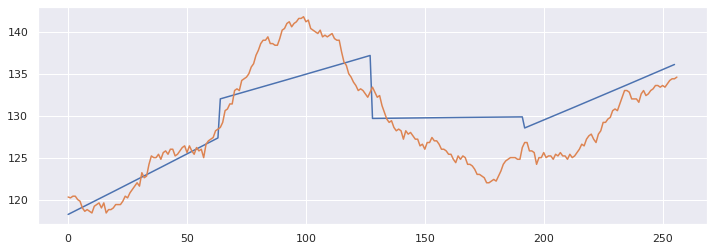

In [22]:
sns.set(rc={'figure.figsize': (12,4)})
plt.plot([ibm.psi(t) for t in range(256)])
plt.plot(h_open);

You can see that the price oscillates around the perceived value of IBM over the year. The clearly visible overshooting of the EPV is due to the implicitely modelled inertia. Here, the root course is obviously the investor's exposure to a momentum incentive.

## Training Data 
For neural network training we need lots of data. Since our model does not (yet) include the a significant influence of our trading on the price, we can save a lot of time when we pre-produce the price history.

#### Some random tickers

In [23]:
N_STOCKS = 4

In [24]:
tickers = list(set(
    ["".join([chr(int(np.random.random()*26+65)) for i in range(4)]) 
     for i in range(2*N_STOCKS)]))[:N_STOCKS]
print(tickers)

['DVCV', 'OUZZ', 'MFVD', 'BZJB']


#### Random sentiments
This function creates random sentiment maps with quarterly discontinuities to mimic earning surprises


In [25]:
def rnd_sentiments(s_max = 1, s_min = -10, n_quarters = 16):
    offset = np.random.randint(64)  # reporting day within the quarter
    s_c = 0
    q = 64 # a quarter
    s = {0: (0, 0)}
    for i in range(n_quarters):
        dst = np.random.normal(.006, .005) / q
        day = i * q + int(np.random.normal(5)) + offset
        s[day] = (s_c, dst)
        s_c = min(s_max, s_c + np.random.normal(0, .1))
        s_c = max(s_min, s_c)
    s[1024] = (0,0)
    return s
#rnd_sentiments()

#### Geo market and segment influences

In [26]:
# US market: bulls and bears
us = GeoMarket('US',                   # A name
               {0: (.1, 0.001),         # Market sentiment over time, starting slightly bullish
                150: (-.1, -0.001),
                300: (-.13, 0),         # Not too bad yet                
                380: (-.1, -0.005),     # A period of hope
                450: (.15, 0.003),
                500: (.25, 0),          # And more hope
                620: ( .1, 0.004),
                700: (.1, 0.001),
                830: (.05, 0.007)
               })   


# Segment sentiment: IT is calming down - the dawn of the new AI winter?
it = Segment('Information Technology', {0: (.0, .001)})

#### The stocks 

In [27]:
duration=1024
stocks = []
for ticker in tickers:
    E_cagr = np.random.normal(6e-2, 4e-2)   # expected compound annual growth rate
    max_effect = 3.0 # Maximum overrating due to sentiment
    psi0 = 50 + 20 * np.random.random() # initial price
    sentiments = rnd_sentiments()       # quarterly impacted stock sentiments
    beta_geo = np.random.normal(.2, .1)       # exposure (beta) to the US market
    beta_it = np.random.normal(.0, .5)       # exposure (beta) to the IT sector
    stock = Stock(name=ticker, e_cagr=E_cagr, max_effect=max_effect, psi0 = psi0,
                    segments = {it: beta_it}, markets = {us: beta_geo},
                    sentiments = sentiments, noise=.4)
    stocks.append(stock)

```psi(t)```, or $\Psi(t)$ is the *Expectation of the perceived value*. 

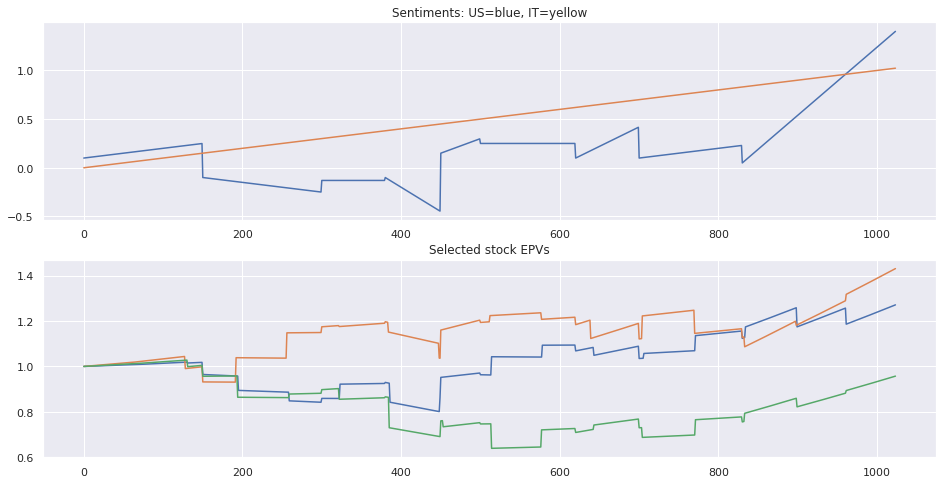

In [28]:
plot_many(2,1, 16, 8, data=[
    [
            [[us.phi(t) for t in range(duration)]],
            [[it.phi(t) for t in range(duration)]]
    ],
    [
            [[stocks[i].psi(t)/stocks[i].psi(0) for t in range(duration)]] 
        for i in [1,2,3]
    ]
], titles=["Sentiments: US=blue, IT=yellow", 'Selected stock EPVs']);

In [29]:
from markets.environment import TradingEnvironment
from markets.stocks_model import MarketFromData

#### Creating batch data
Here, we're creating 4 years worth of market history for the ten stocks we created above. We use a ```TradingEnvironment``` that employs a number (here: 10) of randomly incentivized traders. 

In [30]:
period=1024
market = Market(stocks=stocks, bid_ask=0.1)

config = {
    'num_investors': 10,
    'num_rounds_per_day': 5
}

holdings = {ticker: 10000 for ticker in tickers}
holdings['cash'] = 1e8

environment = TradingEnvironment(config, holdings, market, tx_cost=2.5e-3)

for _ in range(period):
    market.open()
    daily = environment.let_others_trade()
    market.close()


Observe, how realistic some of the charts are! We see overreactions, corrections, various levels of volatility.

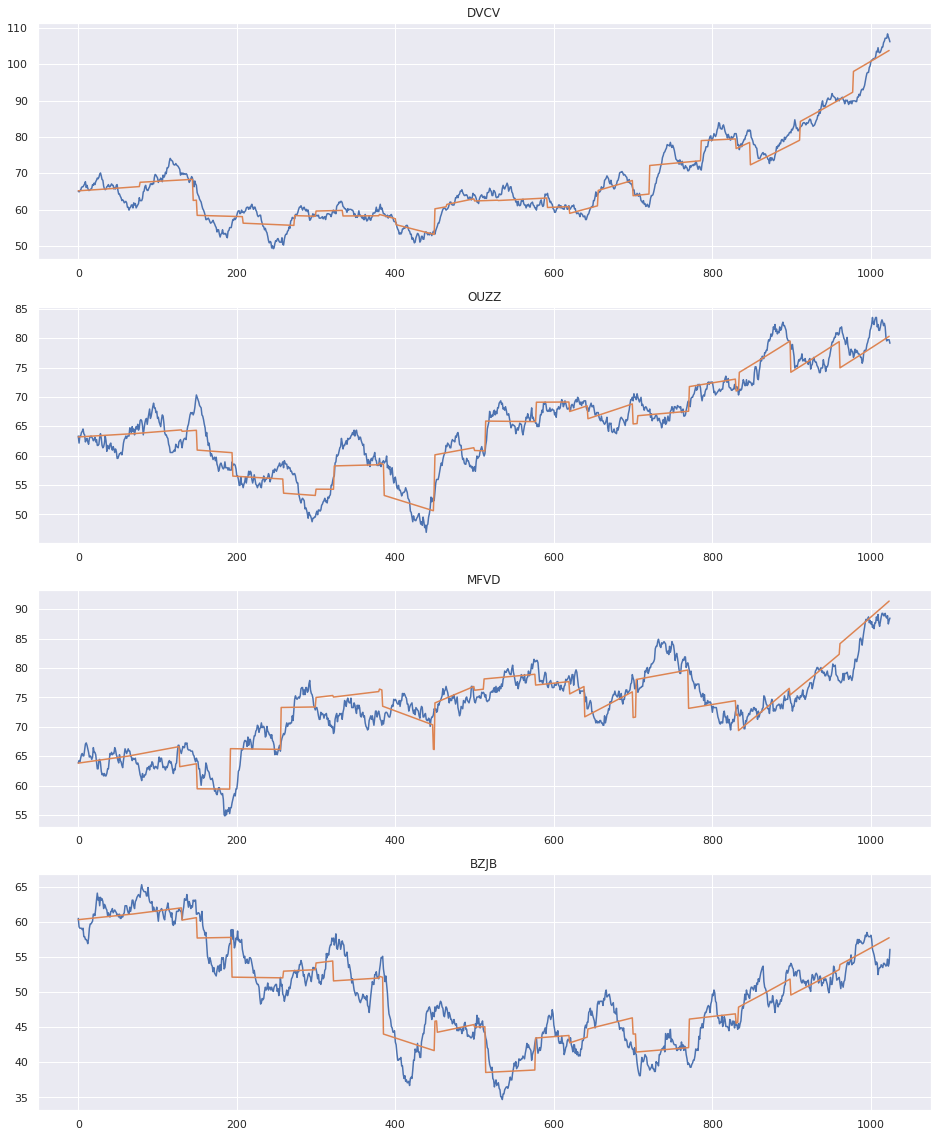

In [31]:
charts = [
    [
        [np.array(market.history[tickers[i]])[:,1]],
        [[stocks[i].psi(t) for t in range(period)]]
    ]
    for i in range(len(tickers))
]
plot_many(N_STOCKS,1,16,5*N_STOCKS, charts, titles=tickers);

### Preparing for Training

In [39]:
from markets.stocks_model import create_stocks, create_chart_data

In [40]:
stocks = create_stocks(10)
stocks

{'KTLY': <markets.dynamic_market.Stock at 0x7f1d4d6c2be0>,
 'MQKE': <markets.dynamic_market.Stock at 0x7f1d4d6c2e80>,
 'WUFO': <markets.dynamic_market.Stock at 0x7f1d4d6c2e48>,
 'EHVG': <markets.dynamic_market.Stock at 0x7f1d4d6c2cc0>,
 'ZNSL': <markets.dynamic_market.Stock at 0x7f1d4d6c2e10>,
 'YOKF': <markets.dynamic_market.Stock at 0x7f1d4d6c2dd8>,
 'HKKX': <markets.dynamic_market.Stock at 0x7f1d4d6c2d68>,
 'IIDQ': <markets.dynamic_market.Stock at 0x7f1d4d6c2f60>,
 'RMXI': <markets.dynamic_market.Stock at 0x7f1d4d6c2eb8>,
 'EMES': <markets.dynamic_market.Stock at 0x7f1d4d5eb080>}

In [41]:
config = {
    'num_investors': 2,
    'num_days': 128 + 1024, # 4 years with half a year of history
    'num_rounds_per_day': 5
}


chart_data = create_chart_data(stocks, config)

In [42]:
chart_data

{'KTLY': {'price': array([ 68.853,  68.453,  68.453, ..., 175.453, 175.653, 175.853]),
  'epv': array([ 68.14,  68.19,  68.25, ..., 196.16, 196.33, 196.49])},
 'MQKE': {'price': array([57.007, 56.807, 56.807, ..., 90.007, 89.807, 90.007]),
  'epv': array([56.82, 56.84, 56.86, ..., 98.85, 98.96, 99.07])},
 'WUFO': {'price': array([54.384, 54.384, 54.384, ..., 62.984, 62.584, 62.384]),
  'epv': array([54.13, 54.14, 54.15, ..., 66.09, 66.11, 66.12])},
 'EHVG': {'price': array([57.594, 57.994, 58.194, ..., 98.794, 98.594, 98.994]),
  'epv': array([ 57.53,  57.55,  57.57, ..., 109.31, 109.47, 109.64])},
 'ZNSL': {'price': array([ 56.937,  56.937,  56.737, ..., 140.537, 140.937, 141.337]),
  'epv': array([ 56.99,  57.04,  57.1 , ..., 164.05, 164.24, 164.42])},
 'YOKF': {'price': array([53.525, 52.925, 52.925, ..., 64.925, 64.925, 64.925]),
  'epv': array([53.11, 53.12, 53.12, ..., 67.19, 67.25, 67.31])},
 'HKKX': {'price': array([ 63.19,  62.79,  63.39, ..., 124.19, 124.79, 124.99]),
  'epv'

In [43]:
with open('charts.pkl', 'wb') as file:
    for i in range(5):
        chart_data = create_chart_data(stocks, config)
        pickle.dump(chart_data, file)

Read the data from the file

In [44]:
data = []
with open('charts.pkl', 'rb') as file:
    r=0
    while True:
        try: 
            data.append(pickle.load(file))
            r+=1
        except EOFError:
            print("Read %s samples." % r)
            break;


Read 5 samples.


In [45]:
sample_no=0
all_charts = np.array([data[sample_no][ticker]['price'] for ticker in stocks])

In [47]:
all_charts[:,0]

array([67.488, 56.72 , 54.878, 57.889, 56.817, 52.946, 63.756, 64.028,
       66.225, 59.046])

In [48]:
class MarketFromData:
    """
    creates a market wrapper for an array or list of shape [N_STOCKS, N_PRICES]
    """
    def __init__(self, data, duration, nh, fee):
        """
        data: an array or list of shape [n_stocks, n_prices]
        nh: max. number of prices in history
        duration: the length of the period that can be served
        requires len(data) == duration + nh
        """
        self.duration = duration
        self.nh = nh
        self.data = np.array(data)
        self.n_securities = np.shape(self.data)[0]
        self.fee = fee
        length = np.shape(self.data)[1]
        if length != duration + nh:
            raise ValueError("record length not sum of duration and history.")
        # Need one more for the log returns
        np.append(self.data, self.data[:,-1:], axis = -1)
                    
    def log_return_history(self, nh, t):
        if t < 0 or t >= duration:
            raise ValueError("t must be between %s and %s" % (0, self.duration - 1))
        if nh > self.nh or nh <= 0:
            raise ValueError("t must be between %s and %s" % (1, self.nh))
        t += self.nh + 1
        
        h = self.data[ :, t-nh-1: t]
        return np.log(h[:, 1:] / h[:, :-1]).T
        
    def prices(self, t):
        return self.data[:, t]

In [49]:
from markets.stocks_model import MarketFromData

In [50]:
market = MarketFromData(all_charts, 1024, 128, fee=2.5e-3)

In [54]:
market.log_return_history(8, 0)

array([[ 0.0029417 ,  0.        ,  0.00765144,  0.        , -0.00319913,
        -0.0037421 , -0.00639429, -0.00317824,  0.        ,  0.        ],
       [ 0.00293307, -0.00354485, -0.0038184 ,  0.00686239,  0.01273558,
        -0.00375616, -0.00321254,  0.        , -0.0059858 ,  0.00636479],
       [ 0.00874794, -0.00712761, -0.00383304, -0.00686239, -0.00316872,
        -0.00377032,  0.        , -0.00318837, -0.00602185, -0.01277034],
       [ 0.00289906,  0.        , -0.00771044, -0.0069098 ,  0.0094762 ,
        -0.00378459,  0.0064148 , -0.0064074 ,  0.00301546,  0.00320791],
       [ 0.00864708, -0.00717878,  0.00771044,  0.        ,  0.00626794,
         0.00378459,  0.00637391, -0.00968875,  0.        , -0.00642614],
       [ 0.        ,  0.        ,  0.        ,  0.00346087,  0.0031193 ,
         0.00377032,  0.00317179,  0.        , -0.00301546, -0.00322862],
       [-0.00575641,  0.00359583,  0.        ,  0.00344893,  0.00620956,
         0.00749825,  0.        ,  0.        